In [2]:
import sounddevice as sd
import soundfile as sf

import numpy as np

from scipy.io.wavfile import write
from scipy.fft import fft, ifft, fftfreq
from scipy.signal import find_peaks

import plotly
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.animation import FuncAnimation
from matplotlib import rcParams


rcParams['animation.ffmpeg_path'] = r"D:\Programme\ffmpeg\ffmpeg-2022-02-07-git-04cc7a5548-full_build\bin\ffmpeg.exe"
rcParams['animation.convert_path'] = f"D:\Programme\ImageMagick\ImageMagick-7.1.0-Q16-HDRI\convert.exe"


# Recording Settings

In [3]:
fs = 44100
interval = 0.2
seconds = 5

interval_step_duration = 1 # in ms
interval_step = int(interval_step_duration / 1000  * fs) # in frames

# 50 ms intervals

N = int(fs * interval)
N_tot = int(fs * seconds)
T = 1 / fs
t = np.linspace(0.0, interval, N, endpoint=False)

In [4]:
hz = fftfreq(N, T)[:N//2]
hz[1] - hz[0]

5.0

# Create or load sound 

In [3]:
myrecording = sd.rec(int(seconds * fs), samplerate=fs, channels=2)
sd.wait()

In [5]:
filename = 'test.wav'
# Extract data and sampling rate from file
myrecording, fs = sf.read(filename, dtype='float32')  

In [6]:
myrecording.shape

(220500, 2)

# Fourier Transform

In [21]:
def four_trans_seq(audio, n_dom=6, fs=fs, seconds=seconds, N=N, T=T, interval_step=interval_step):
    n_dom = 6
    xf = np.zeros(((fs * seconds - N) // interval_step, N // 2), dtype="float64")
    xft = np.zeros(((fs * seconds - N) // interval_step, N ), dtype="float64")
    yf = np.zeros(((fs * seconds - N) // interval_step , N, 2), dtype="complex64")
    k_dom_ind = np.zeros(((fs * seconds - N) // interval_step, n_dom, 2), dtype="int32")
    
    for i in range((int(fs * seconds) - N)//interval_step):
        # get axis
        xf[i,:] = fftfreq(N, T)[:N//2] # positive frequencies
        xft[i,:] = fftfreq(N, T) # all frequencies (redundant)

        yf[i,:,0] = fft(audio[i*interval_step:i*interval_step+N,0]) # fft of channel 1
        yf[i,:,1] = fft(audio[i*interval_step:i*interval_step+N,1]) # fft of channel 2

        yf0_tmp = np.abs(yf[i, :, 0])[:N//2]
        yf1_tmp = np.abs(yf[i, :, 1])[:N//2]
        # dominant frequencies
        # channel 1
        peaks1, _ = find_peaks(yf0_tmp, height = 0, distance = int(40 / (xf[0,1] - xf[0,0])), prominence = 0.5)
        if peaks1.shape[0] >= n_dom:
            idx = np.argpartition(yf0_tmp[peaks1], -n_dom)[-n_dom:]
            index = idx[np.argsort(-yf0_tmp[peaks1][idx])]
            k_dom_ind[i, :, 0] = peaks1[index]
            #k_dom[i,:, 0]= xf[i, k]
            #k_ind = peaks1[index]
            #if i > 1000:
            #    print(xf[i, peaks1], yf0_tmp[peaks1])
            ##    #print(xf[idx], yf0_tmp[idx])
            #    print(xf[i, peaks1][indices], yf0_tmp[peaks1][indices])
            #    plt.plot(xf[i,:], yf0_tmp)
            #    plt.scatter(k_dom[i,:,0],yf0_tmp[k_ind], color = "red")
            #    print(k_dom[i, :,0], )
            #    break
        # channel 2
        peaks2, _ = find_peaks(yf1_tmp, height = 0, distance = int(40 / (xf[0,1] - xf[0,0])), prominence = 0.5)
        if peaks2.shape[0] >= n_dom:
            idx = np.argpartition(yf1_tmp[peaks2], -n_dom)[-n_dom:]
            index = idx[np.argsort(-yf1_tmp[peaks2][idx])]
            k_dom_ind[i, :, 1] = peaks2[index]
    
    return xf, yf, k_dom_ind

def four_trans_tot(audio, N=N_tot, T=T):
    yf_tot = fft(audio[:, 0])
    xf_tot = fftfreq(N, T)[:N//2]
    xft_tot = fftfreq(N, T)
    
    return xf_tot, yf_tot

In [22]:
xf, yf, k_dom_ind = four_trans_seq(myrecording)

In [23]:
xf_tot, yf_tot = four_trans_tot(myrecording)

In [24]:
yf_tot.shape

(220500,)

# Transform Audio

In [25]:
def shift(arr, num, fill_value=0.0):
    result = np.empty_like(arr)
    if num > 0:
        result[:num] = fill_value
        result[num:N_tot // 2] = arr[:(N_tot // 2) - num]
        
        # move negative freq. as well
        result[-num:] = fill_value
        result[N_tot // 2:-num] = arr[(N_tot // 2) + num:]
    elif num < 0:
        raise ValueError("Not implemented")
        result[num:] = fill_value
        result[:num] = arr[-num:]
    else:
        result[:] = arr
    return result

def shiftHz(arr, hz):
    num = int(hz / (xf_tot[1] - xf_tot[0]))
    return shift(arr, num)

In [202]:
xft_tot[-5:]

array([-1. , -0.8, -0.6, -0.4, -0.2])

In [180]:
xf_tot[1] - xf_tot[0]

0.2

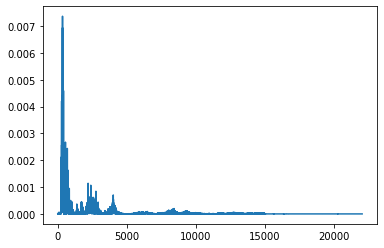

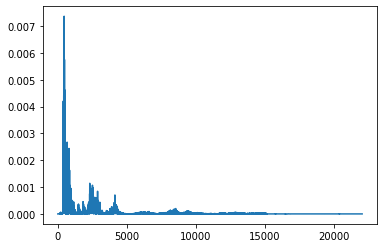

In [26]:
plt.plot(xf_tot, 2.0/N_tot * np.abs(yf_tot)[:N_tot//2])
plt.show()
yf_tot = shiftHz(yf_tot, 120)
plt.plot(xf_tot, 2.0/N_tot * np.abs(yf_tot)[:N_tot//2])
plt.show()

# Plot result

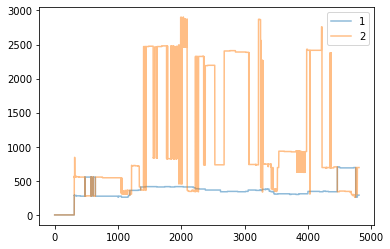

In [27]:
plt.plot([xf[i, ent] for i, ent in enumerate(k_dom_ind[:, 0:2, 0])], label=["1", "2"], alpha=0.5) #["1", "2", "3", "4", "5", "6"]
plt.legend()
plt.show()
#plt.close('all')

In [30]:
%matplotlib qt

n_dom = 6

fig, axes = plt.subplots(2, 2)
axes[0, 0].set_xlim(1,max(xf[0,:]))
axes[0, 0].set_ylim(0,0.1)
axes[0, 1].set_ylim(1, max(xf[0,:]))

axes[0, 0].set_xscale("log")
axes[0, 1].set_yscale("log")

axes[1, 0].set_xlim(80,600)
axes[1, 0].set_ylim(0,0.1)
axes[1, 1].set_ylim(80, 600)

line, = axes[0, 0].plot(0,0)
scat = axes[0, 0].scatter(xf[0, k_dom_ind[0, :, 0]],2.0/N * np.abs(yf[0,:,0])[:N//2][k_dom_ind[0, :, 0]], color="red")

barcollection = axes[0, 1].bar(np.arange(1, n_dom+1),np.zeros((n_dom,)))
line_det, = axes[1, 0].plot(0,0)
scat_det = axes[1, 0].scatter(xf[0, k_dom_ind[0, :, 0]],2.0/N * np.abs(yf[0,:,0])[:N//2][k_dom_ind[0, :, 0]], color="red")

barcollection_det = axes[1, 1].bar(np.arange(1, n_dom+1),np.zeros((n_dom,)))
#string = f"Maximal Frequency: - Hz"
#label = ax1.text(0, 0, string[0], ha='center', va='center', fontsize=20, color="Red")

def animation_frame(i):
    ind = int(round(i))
    line.set_xdata(xf[ind,:])
    line.set_ydata(2.0/N * np.abs(yf[ind,:,0])[:N//2])
    
    line_det.set_xdata(xf[ind,:])
    line_det.set_ydata(2.0/N * np.abs(yf[ind,:,0])[:N//2])
    
    x_tmp = xf[ind, k_dom_ind[ind, :, 0]]
    y_tmp = 2.0/N * np.abs(yf[ind,:,0])[:N//2][k_dom_ind[ind, :, 0]]
    data = np.vstack((x_tmp, y_tmp)).transpose()
    
    # draw points for maxima
    scat.set_offsets(data)
    scat_det.set_offsets(data)
    
    for j, b in enumerate(barcollection):
        b.set_height(xf[ind, k_dom_ind[ind,j,0]])
   
    for j, b in enumerate(barcollection_det):
        b.set_height(xf[ind, k_dom_ind[ind,j,0]])
    #label.set_text(f"Maximal Frequency: {k_dom[ind,0]} Hz")
    return line,

animation = FuncAnimation(fig, func=animation_frame, frames=np.arange(0, xf.shape[0], (16 + 2/3)/interval_step_duration), interval=(16 + 2/3)/interval_step_duration, blit=False) 
#plt.show()


#animation.save('test.gif', writer='imagemagick', fps=30,)
animation.save('test.mp4', writer='ffmpeg', fps=60)


In [130]:
!ffmpeg -i test.mp4 -i test.wav -c:v copy -c:a aac output.mp4 -y

ffmpeg version 2022-02-07-git-04cc7a5548-full_build-www.gyan.dev Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 11.2.0 (Rev7, Built by MSYS2 project)
  configuration: --enable-gpl --enable-version3 --enable-static --disable-w32threads --disable-autodetect --enable-fontconfig --enable-iconv --enable-gnutls --enable-libxml2 --enable-gmp --enable-bzlib --enable-lzma --enable-libsnappy --enable-zlib --enable-librist --enable-libsrt --enable-libssh --enable-libzmq --enable-avisynth --enable-libbluray --enable-libcaca --enable-sdl2 --enable-libdav1d --enable-libdavs2 --enable-libuavs3d --enable-libzvbi --enable-librav1e --enable-libsvtav1 --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs2 --enable-libxvid --enable-libaom --enable-libopenjpeg --enable-libvpx --enable-mediafoundation --enable-libass --enable-frei0r --enable-libfreetype --enable-libfribidi --enable-libvidstab --enable-libvmaf --enable-libzimg --enable-amf --enable-cuda-llvm --enable-cuvid --ena

In [100]:
yf.shape

(2956, 2205, 2)

In [49]:
yf[ (xft < 0)] = 0 #(xft>5000) |

In [69]:
yf -= 200

In [78]:
xf.dtype

dtype('float64')

In [71]:
yf[(xft > 50) & (xft < 150)] *= 0.1
yf[(xft > 300) & (xft < 600)] *= 2

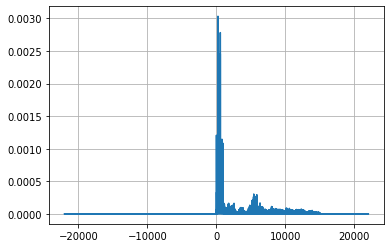

In [72]:
plt.plot(xft, 2.0/N * np.abs(yf))

plt.grid()

plt.show()

In [63]:
fig = px.line(x=xf, y=2.0/N * np.abs(yf[0:N//2]), title='Frequency Spectrum')
fig.show()

# Transform back

In [219]:
y = ifft(np.tile(yf_tot, 2))

In [224]:
y = ifft(yf_tot)

# Play result

In [156]:
sd.play(myrecording, fs)

In [226]:
sd.play(np.real(y), fs)

In [9]:
write('test.wav', fs, myrecording)